<a href="https://colab.research.google.com/github/Nightmare125/Machine-Learning/blob/main/Apriori_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Groceries_dataset.csv to Groceries_dataset.csv


# Part 1: Data Preparation and Exploration

## Task 1.1: Load and Explore the Dataset

### Load the dataset

In [3]:
df = pd.read_csv('Groceries_dataset.csv')
# TODO 1.1.2: Explore the dataset structure
# Print dataset shape, first 5 rows, and basic info
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset info:")
df.info()

# TODO 1.1.3: Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# TODO 1.1.4: Examine unique values
# Count unique members, items, and date range
print(f"\nUnique members: {df['Member_number'].nunique()}")
print(f"Unique items: {df['itemDescription'].nunique()}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

Dataset shape: (38765, 3)

First 5 rows:
   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB

Missing values:
Member_number      0
Date               0
itemDescription    0
dtype: int64

Unique members: 3898
Unique items: 167
Date range: 01-01-2014 to 31-10-2015


## Task 1.2: Transform Data into Transaction Format

In [4]:
def create_transaction_list(df):
    """
    Convert the dataframe into a list of transactions (itemsets)
    Each transaction is a list of items bought together by the same member on the same date

    TODO 1.2.1: Implement this function
    Args:
        df: DataFrame with columns Member_number, Date, itemDescription
    Returns:
        list: List of transactions, where each transaction is a list of items

    Hints:
    - Group by Member_number AND Date to get transactions
    - Use groupby() and apply(list) to collect items
    - Return the list of item lists
    """
    # Step 1 & 2: Group by member and date, aggregate items into lists
    grouped = df.groupby(['Member_number', 'Date'])['itemDescription'].apply(list)
    # Step 3: Extract the list of transactions
    transactions = grouped.tolist()
    return transactions

# TODO 1.2.2: Create transaction list and display statistics
transactions = create_transaction_list(df)

print(f"Total transactions: {len(transactions)}")
print(f"First 5 transactions:")
for i, transaction in enumerate(transactions[:5]):
    print(f"  {i+1}: {transaction}")

# TODO 1.2.3: Calculate transaction statistics
# Calculate: average, min, max items per transaction
transaction_lengths = [len(t) for t in transactions]
print(f"\nTransaction length statistics:")
print(f"Average items per transaction: {np.mean(transaction_lengths):.2f}")
print(f"Min items: {np.min(transaction_lengths)}")
print(f"Max items: {np.max(transaction_lengths)}")

Total transactions: 14963
First 5 transactions:
  1: ['sausage', 'whole milk', 'semi-finished bread', 'yogurt']
  2: ['whole milk', 'pastry', 'salty snack']
  3: ['canned beer', 'misc. beverages']
  4: ['sausage', 'hygiene articles']
  5: ['soda', 'pickled vegetables']

Transaction length statistics:
Average items per transaction: 2.59
Min items: 2
Max items: 11


## Task 1.3: Visualize Data Patterns


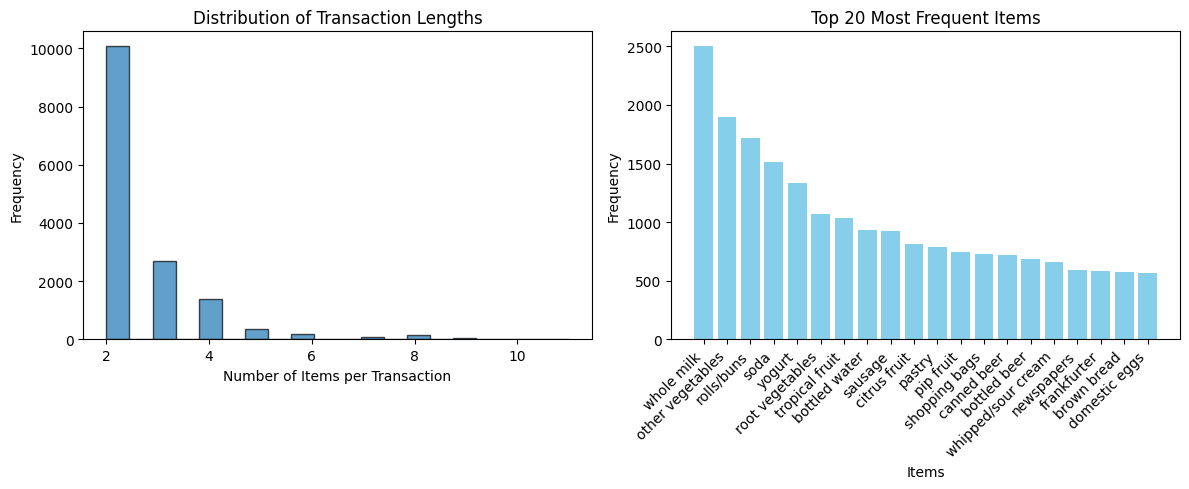


Top 10 most frequent items:
  whole milk: 2502 (6.45%)
  other vegetables: 1898 (4.90%)
  rolls/buns: 1716 (4.43%)
  soda: 1514 (3.91%)
  yogurt: 1334 (3.44%)
  root vegetables: 1071 (2.76%)
  tropical fruit: 1032 (2.66%)
  bottled water: 933 (2.41%)
  sausage: 924 (2.38%)
  citrus fruit: 812 (2.09%)


In [5]:
# TODO 1.3.1: Create transaction length distribution plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# TODO: Create histogram of transaction_lengths
plt.hist(transaction_lengths, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Items per Transaction')
plt.ylabel('Frequency')
plt.title('Distribution of Transaction Lengths')

# TODO 1.3.2: Create most frequent items plot
# Step 1: Flatten all items from all transactions into one list
all_items = [item for transaction in transactions for item in transaction]

# Step 2: Count item frequencies
item_counts = Counter(all_items)
top_20_items = item_counts.most_common(20)

plt.subplot(1, 2, 2)
# TODO: Create bar plot of top 20 items
items = [item[0] for item in top_20_items]
counts = [item[1] for item in top_20_items]
plt.bar(items, counts, color='skyblue')
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Items')
# TODO: Set x-axis labels with rotation
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# TODO 1.3.3: Print top 10 items with percentages
print("\nTop 10 most frequent items:")
total_items = len(all_items)
for item, count in top_20_items[:10]:
    percentage = (count / total_items) * 100
    print(f"  {item}: {count} ({percentage:.2f}%)")

# Part 2: Implement Apriori Algorithm Core Functions


## Task 2.1: Calculate Support


In [6]:
def calculate_support(itemset, transactions):
    """
    Calculate support for an itemset
    Support = (Number of transactions containing itemset) / (Total number of transactions)

    TODO 2.1.1: Implement support calculation
    Args:
        itemset: frozenset of items to check
        transactions: list of transactions (lists of items)

    Returns:
        float: support value between 0 and 1

    Hints:
    - Loop through all transactions
    - Check if itemset is a subset of each transaction
    - Count how many transactions contain the itemset
    - Divide by total number of transactions
    """
    count = 0
    for transaction in transactions:
        if itemset.issubset(set(transaction)):
            count += 1
    return count / len(transactions)

# TODO 2.1.2: Test the function
test_itemset = frozenset(['whole milk'])
support = calculate_support(test_itemset, transactions)
print(f"Support for {set(test_itemset)}: {support:.4f}")

# TODO 2.1.3: Test with a 2-itemset
test_itemset_2 = frozenset(['whole milk', 'rolls/buns'])  # Choose two items
support_2 = calculate_support(test_itemset_2, transactions)
print(f"Support for {set(test_itemset_2)}: {support_2:.4f}")

Support for {'whole milk'}: 0.1579
Support for {'rolls/buns', 'whole milk'}: 0.0140


## Task 2.2: Generate Candidate Itemsets

In [7]:
def generate_candidates(frequent_itemsets, k):
    """
    Generate candidate itemsets of size k from frequent itemsets of size k-1
    This uses the "join" step of the Apriori algorithm

    TODO 2.2.1: Implement candidate generation
    Args:
        frequent_itemsets: set of frequent itemsets of size k-1
        k: size of candidates to generate

    Returns:
        set of candidate itemsets of size k

    Hints:
    - Convert frequent_itemsets to a list for easier iteration
    - For each pair of itemsets, compute their union
    - Only keep unions that have exactly k items
    - Use frozenset for immutable sets
    """
    candidates = set()
    frequent_list = list(frequent_itemsets)

    for i in range(len(frequent_list)):
        for j in range(i + 1, len(frequent_list)):
            itemset1 = frequent_list[i]
            itemset2 = frequent_list[j]
            # Join step: combine two (k-1)-itemsets if they differ by only one item
            union_set = itemset1.union(itemset2)
            if len(union_set) == k:
                candidates.add(union_set)

    return candidates

# TODO 2.2.2: Test candidate generation
frequent_1_test = {frozenset(['A']), frozenset(['B']), frozenset(['C'])}
candidates_2_test = generate_candidates(frequent_1_test, 2)
print(f"Generated 2-itemset candidates: {[set(c) for c in candidates_2_test]}")

# TODO 2.2.3: Test with larger example
frequent_2_test = {frozenset(['A', 'B']), frozenset(['A', 'C']), frozenset(['B', 'C'])}
candidates_3_test = generate_candidates(frequent_2_test, 3)
print(f"Generated 3-itemset candidates: {[set(c) for c in candidates_3_test]}")

Generated 2-itemset candidates: [{'B', 'C'}, {'A', 'B'}, {'A', 'C'}]
Generated 3-itemset candidates: [{'A', 'B', 'C'}]


## Task 2.3: Find Frequent Itemsets (Main Apriori Algorithm)


In [8]:
def find_frequent_itemsets(transactions, min_support):
    """
    Find all frequent itemsets using the Apriori algorithm

    TODO 2.3.1: Implement the complete Apriori algorithm
    Args:
        transactions: list of transactions
        min_support: minimum support threshold

    Returns:
        dict: {k: set of frequent k-itemsets}

    Algorithm Steps:
    1. Find frequent 1-itemsets
    2. For k = 2, 3, 4, ... until no more frequent itemsets:
        a. Generate candidate k-itemsets from frequent (k-1)-itemsets
        b. Test each candidate for minimum support
        c. Keep candidates that meet minimum support
    3. Return all frequent itemsets
    """
    frequent_itemsets = {}

    # TODO 2.3.2: Find frequent 1-itemsets
    print("Finding frequent 1-itemsets...")

    # Step 1: Get all unique items
    all_items = set(item for transaction in transactions for item in transaction)

    # Step 2: Test each item for frequency
    frequent_1 = set()
    for item in all_items:
        itemset = frozenset([item])
        support = calculate_support(itemset, transactions)
        if support >= min_support:
            frequent_1.add(itemset)

    frequent_itemsets[1] = frequent_1
    print(f"Found {len(frequent_1)} frequent 1-itemsets")

    # TODO 2.3.3: Generate frequent k-itemsets for k > 1
    k = 2
    while frequent_itemsets[k-1]:  # Continue while previous level has itemsets
        print(f"Finding frequent {k}-itemsets...")

        # TODO: Generate candidates using your generate_candidates function
        candidates = generate_candidates(frequent_itemsets[k-1], k)

        # TODO: Test candidates for frequency
        frequent_k = set()
        for candidate in candidates:
            support = calculate_support(candidate, transactions)
            if support >= min_support:
                frequent_k.add(candidate)

        # TODO: Add frequent_k to results if it's not empty, otherwise break
        if frequent_k:
            frequent_itemsets[k] = frequent_k
            print(f"Found {len(frequent_k)} frequent {k}-itemsets")
            k += 1
        else:
            break

    return frequent_itemsets

# TODO 2.3.4: Run the algorithm
min_support = 0.01  # 1% minimum support
print(f"\nRunning Apriori with minimum support = {min_support}")
start_time = time.time()
frequent_itemsets = find_frequent_itemsets(transactions, min_support)
end_time = time.time()
print(f"Apriori algorithm finished in {end_time - start_time:.2f} seconds.")

# TODO 2.3.5: Display results summary
print(f"\nFrequent itemsets summary:")
for k, itemsets in frequent_itemsets.items():
    print(f"  {k}-itemsets: {len(itemsets)}")

# TODO 2.3.6: Show some examples of frequent itemsets
print(f"\nExample frequent itemsets:")
for k, itemsets in frequent_itemsets.items():
    if itemsets:
        example_itemsets = list(itemsets)[:3]  # Show first 3
        for itemset in example_itemsets:
            support = calculate_support(itemset, transactions)
            print(f"  {set(itemset)}: support = {support:.4f}")


Running Apriori with minimum support = 0.01
Finding frequent 1-itemsets...
Found 64 frequent 1-itemsets
Finding frequent 2-itemsets...
Found 5 frequent 2-itemsets
Finding frequent 3-itemsets...
Apriori algorithm finished in 7.48 seconds.

Frequent itemsets summary:
  1-itemsets: 64
  2-itemsets: 5

Example frequent itemsets:
  {'processed cheese'}: support = 0.0102
  {'specialty chocolate'}: support = 0.0160
  {'hard cheese'}: support = 0.0147
  {'soda', 'whole milk'}: support = 0.0116
  {'other vegetables', 'rolls/buns'}: support = 0.0106
  {'rolls/buns', 'whole milk'}: support = 0.0140


# Part 3: Generate Association Rules


## Task 3.1: Implement Association Rule Generation


In [9]:
def generate_association_rules(frequent_itemsets, transactions, min_confidence):
    """
    Generate association rules from frequent itemsets
    Rule: X → Y where X ∪ Y is a frequent itemset

    TODO 3.1.1: Implement association rule generation
    Args:
        frequent_itemsets: dict of frequent itemsets
        transactions: list of transactions
        min_confidence: minimum confidence threshold

    Returns:
        list of association rules with metrics

    For each frequent itemset of size ≥ 2:
    1. Generate all possible ways to split it into antecedent → consequent
    2. Calculate confidence = support(antecedent ∪ consequent) / support(antecedent)
    3. Keep rules with confidence ≥ min_confidence
    4. Calculate lift = confidence / support(consequent)
    """
    rules = []

    # TODO 3.1.2: Generate rules from itemsets of size 2 and above
    # Iterate through itemsets from size 2 upwards
    for k in sorted(frequent_itemsets.keys()):
        if k < 2:
            continue
        for itemset in frequent_itemsets[k]:
            items = list(itemset)

            # TODO: Generate all possible antecedent-consequent pairs
            # For itemset {A,B,C}, possible antecedents: {A}, {B}, {C}, {A,B}, {A,C}, {B,C}

            # Loop through all possible sizes for the antecedent (from 1 to k-1)
            for i in range(1, len(items)):  # i is size of antecedent
                for antecedent_items in combinations(items, i):
                    antecedent = frozenset(antecedent_items)
                    consequent = itemset - antecedent

                    # TODO 3.1.3: Calculate metrics
                    support_itemset = calculate_support(itemset, transactions)
                    support_antecedent = calculate_support(antecedent, transactions)

                    if support_antecedent > 0:
                        # TODO: Calculate confidence
                        confidence = support_itemset / support_antecedent

                        if confidence >= min_confidence:
                            # TODO: Calculate lift
                            support_consequent = calculate_support(consequent, transactions)
                            lift = confidence / support_consequent if support_consequent > 0 else 0

                            # TODO: Add rule to results
                            rules.append({
                                'antecedent': set(antecedent),
                                'consequent': set(consequent),
                                'support': support_itemset,
                                'confidence': confidence,
                                'lift': lift
                            })

    return rules

# TODO 3.1.4: Generate rules and analyze them
min_confidence = 0.3  # 30% minimum confidence
print(f"Generating association rules with minimum confidence = {min_confidence}")

rules = generate_association_rules(frequent_itemsets, transactions, min_confidence)
print(f"Generated {len(rules)} association rules")

# TODO 3.1.5: Sort rules by confidence and display top 10
# Hint: Use rules.sort(key=lambda x: x['confidence'], reverse=True)
rules.sort(key=lambda x: x['confidence'], reverse=True)

print(f"\nTop 10 association rules by confidence:")
# TODO: Loop through top 10 rules and display them nicely
for i, rule in enumerate(rules[:10]):
    print(f"  {i+1}. {rule['antecedent']} -> {rule['consequent']}")
    print(f"     Support: {rule['support']:.4f}, Confidence: {rule['confidence']:.4f}, Lift: {rule['lift']:.4f}")

Generating association rules with minimum confidence = 0.3
Generated 0 association rules

Top 10 association rules by confidence:


## Task 3.2: Rule Analysis and Filtering


In [10]:
def analyze_rules(rules):
    """
    Analyze and filter association rules based on different criteria

    TODO 3.2.1: Implement comprehensive rule analysis
    """
    print("=== ASSOCIATION RULES ANALYSIS ===\n")

    # TODO 3.2.2: Rules with highest lift
    print("TOP 10 RULES BY LIFT (Most surprising associations):")
    rules_by_lift = sorted(rules, key=lambda x: x['lift'], reverse=True)
    for i, rule in enumerate(rules_by_lift[:10]):
        print(f"  {i+1}. {rule['antecedent']} -> {rule['consequent']}")
        print(f"     Support: {rule['support']:.4f}, Confidence: {rule['confidence']:.4f}, Lift: {rule['lift']:.4f}")

    # TODO 3.2.3: Rules with highest support
    print("\nTOP 10 RULES BY SUPPORT (Most frequent associations):")
    rules_by_support = sorted(rules, key=lambda x: x['support'], reverse=True)
    for i, rule in enumerate(rules_by_support[:10]):
        print(f"  {i+1}. {rule['antecedent']} -> {rule['consequent']}")
        print(f"     Support: {rule['support']:.4f}, Confidence: {rule['confidence']:.4f}, Lift: {rule['lift']:.4f}")

    # TODO 3.2.4: Balanced rules (good confidence AND lift)
    print(f"\nBALANCED RULES (Confidence > 0.5 and Lift > 1.5):")
    balanced_rules = [
        rule for rule in rules if rule['confidence'] > 0.5 and rule['lift'] > 1.5
    ]
    # Sort by confidence * lift product for a combined score
    balanced_rules_sorted = sorted(balanced_rules, key=lambda x: x['confidence'] * x['lift'], reverse=True)
    for i, rule in enumerate(balanced_rules_sorted[:10]): # Show top 10 balanced rules
        print(f"  {i+1}. {rule['antecedent']} -> {rule['consequent']}")
        print(f"     Support: {rule['support']:.4f}, Confidence: {rule['confidence']:.4f}, Lift: {rule['lift']:.4f}")

    # TODO 3.2.5: Rules for specific items
    print(f"\nRULES INVOLVING 'whole milk':")
    whole_milk_rules = [
        rule for rule in rules
        if 'whole milk' in rule['antecedent'] or 'whole milk' in rule['consequent']
    ]
    # Sort by confidence for better readability
    whole_milk_rules_sorted = sorted(whole_milk_rules, key=lambda x: x['confidence'], reverse=True)
    for i, rule in enumerate(whole_milk_rules_sorted[:10]): # Show top 10 rules involving whole milk
        print(f"  {i+1}. {rule['antecedent']} -> {rule['consequent']}")
        print(f"     Support: {rule['support']:.4f}, Confidence: {rule['confidence']:.4f}, Lift: {rule['lift']:.4f}")

# TODO 3.2.6: Run the analysis
analyze_rules(rules)

=== ASSOCIATION RULES ANALYSIS ===

TOP 10 RULES BY LIFT (Most surprising associations):

TOP 10 RULES BY SUPPORT (Most frequent associations):

BALANCED RULES (Confidence > 0.5 and Lift > 1.5):

RULES INVOLVING 'whole milk':


# Part 4: Visualization and Business Insights


## Task 4.1: Create Rule Visualizations


In [11]:
def visualize_rules(rules):
    """
    Create visualizations for association rules

    TODO 4.1.1: Implement rule visualizations
    """
    if not rules:
        print("No rules to visualize!")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Association Rule Metrics Distributions and Relationships', fontsize=16)

    # TODO 4.1.2: Extract metrics for plotting
    supports = [rule['support'] for rule in rules]
    confidences = [rule['confidence'] for rule in rules]
    lifts = [rule['lift'] for rule in rules]

    # TODO 4.1.3: Support vs Confidence scatter plot (colored by Lift)
    scatter = axes[0,0].scatter(supports, confidences, c=lifts, cmap='viridis', alpha=0.6)
    axes[0,0].set_xlabel('Support')
    axes[0,0].set_ylabel('Confidence')
    axes[0,0].set_title('Support vs Confidence (colored by Lift)')
    plt.colorbar(scatter, ax=axes[0,0], label='Lift')
    axes[0,0].grid(True, linestyle='--', alpha=0.7)

    # TODO 4.1.4: Lift distribution histogram
    axes[0,1].hist(lifts, bins=30, edgecolor='black', alpha=0.7)
    axes[0,1].axvline(1, color='red', linestyle='--', label='Lift = 1 (No Association)')
    axes[0,1].set_xlabel('Lift')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Distribution of Lift Values')
    axes[0,1].legend()
    axes[0,1].grid(True, linestyle='--', alpha=0.7)

    # TODO 4.1.5: Confidence distribution histogram
    axes[1,0].hist(confidences, bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
    axes[1,0].set_xlabel('Confidence')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Distribution of Confidence Values')
    axes[1,0].grid(True, linestyle='--', alpha=0.7)

    # TODO 4.1.6: Support distribution histogram
    axes[1,1].hist(supports, bins=30, edgecolor='black', alpha=0.7, color='coral')
    axes[1,1].set_xlabel('Support')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Distribution of Support Values')
    axes[1,1].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.show()

# TODO 4.1.7: Create visualizations
visualize_rules(rules)

No rules to visualize!


## Task 4.2: Business Insights and Recommendations


In [12]:
def generate_business_insights(rules, transactions):
    """
    Generate actionable business insights from association rules

    TODO 4.2.1: Implement business insight generation
    """
    print("=== BUSINESS INSIGHTS AND RECOMMENDATIONS ===\n")

    # Sort rules by confidence for cross-selling
    rules_sorted_by_confidence = sorted(rules, key=lambda x: x['confidence'], reverse=True)
    # Sort rules by lift for surprising associations (store layout, marketing)
    rules_sorted_by_lift = sorted(rules, key=lambda x: x['lift'], reverse=True)
    # Sort rules by support for frequently bought together items
    rules_sorted_by_support = sorted(rules, key=lambda x: x['support'], reverse=True)


    # TODO 4.2.2: Cross-selling opportunities
    print("CROSS-SELLING OPPORTUNITIES:")
    print("When customers buy these items, they're likely to also buy:")
    # Find rules with high confidence (> 60%) and lift > 1
    cross_sell_rules = [
        rule for rule in rules_sorted_by_confidence if rule['confidence'] > 0.6 and rule['lift'] > 1
    ][:5] # Top 5
    if cross_sell_rules:
        for i, rule in enumerate(cross_sell_rules):
            print(f"  {i+1}. If a customer buys {list(rule['antecedent'])}, they are {rule['confidence']:.2%} likely to also buy {list(rule['consequent'])}.")
    else:
        print("  No strong cross-selling rules found at this confidence level.")


    # TODO 4.2.3: Product bundling suggestions
    print(f"\nPRODUCT BUNDLING SUGGESTIONS:")
    print("Items frequently bought together (high support + good lift):")
    # Find rules with support > 0.02 and lift > 1.3
    bundle_rules = [
        rule for rule in rules_sorted_by_lift if rule['support'] > 0.02 and rule['lift'] > 1.3
    ][:5] # Top 5
    if bundle_rules:
        for i, rule in enumerate(bundle_rules):
            print(f"  {i+1}. Consider bundling {list(rule['antecedent'])} with {list(rule['consequent'])} (Support: {rule['support']:.2%}, Lift: {rule['lift']:.2f}).")
    else:
        print("  No strong product bundling suggestions found at these thresholds.")

    # TODO 4.2.4: Store layout recommendations
    print(f"\nSTORE LAYOUT RECOMMENDATIONS:")
    print("Place these items near each other:")
    # Find rules with highest lift values (indicating strong, non-obvious relationships)
    layout_rules = [
        rule for rule in rules_sorted_by_lift if rule['lift'] > 1.5
    ][:5] # Top 5
    if layout_rules:
        for i, rule in enumerate(layout_rules):
            print(f"  {i+1}. Items {list(rule['antecedent'])} and {list(rule['consequent'])} show a strong positive association (Lift: {rule['lift']:.2f}). Consider placing them in proximity.")
    else:
        print("  No strong store layout recommendations based on high lift.")

    # TODO 4.2.5: Marketing insights
    print(f"\nMARKETING INSIGHTS:")
    # Find unexpected associations (high lift, moderate support)
    marketing_rules = [
        rule for rule in rules_sorted_by_lift if rule['lift'] > 2 and rule['support'] > 0.005
    ][:5] # Top 5
    if marketing_rules:
        for i, rule in enumerate(marketing_rules):
            print(f"  {i+1}. Target customers who buy {list(rule['antecedent'])} with promotions for {list(rule['consequent'])}. This is a surprising association (Lift: {rule['lift']:.2f}).")
    else:
        print("  No specific marketing insights found with high lift and moderate support.")

# TODO 4.2.6: Generate insights
generate_business_insights(rules, transactions)

=== BUSINESS INSIGHTS AND RECOMMENDATIONS ===

CROSS-SELLING OPPORTUNITIES:
When customers buy these items, they're likely to also buy:
  No strong cross-selling rules found at this confidence level.

PRODUCT BUNDLING SUGGESTIONS:
Items frequently bought together (high support + good lift):
  No strong product bundling suggestions found at these thresholds.

STORE LAYOUT RECOMMENDATIONS:
Place these items near each other:
  No strong store layout recommendations based on high lift.

MARKETING INSIGHTS:
  No specific marketing insights found with high lift and moderate support.


# Part 5: Advanced Analysis and Optimization


## Task 5.1: Parameter Sensitivity Analysis


=== PARAMETER SENSITIVITY ANALYSIS ===

Testing minimum support = 0.005
Finding frequent 1-itemsets...
Found 89 frequent 1-itemsets
Finding frequent 2-itemsets...
Found 37 frequent 2-itemsets
Finding frequent 3-itemsets...
  Testing minimum confidence = 0.2
    - Found 0 rules with avg confidence 0.00, avg lift 0.00
  Testing minimum confidence = 0.3
    - Found 0 rules with avg confidence 0.00, avg lift 0.00
  Testing minimum confidence = 0.5
    - Found 0 rules with avg confidence 0.00, avg lift 0.00
  Testing minimum confidence = 0.7
    - Found 0 rules with avg confidence 0.00, avg lift 0.00
Testing minimum support = 0.01
Finding frequent 1-itemsets...
Found 64 frequent 1-itemsets
Finding frequent 2-itemsets...
Found 5 frequent 2-itemsets
Finding frequent 3-itemsets...
  Testing minimum confidence = 0.2
    - Found 0 rules with avg confidence 0.00, avg lift 0.00
  Testing minimum confidence = 0.3
    - Found 0 rules with avg confidence 0.00, avg lift 0.00
  Testing minimum confiden

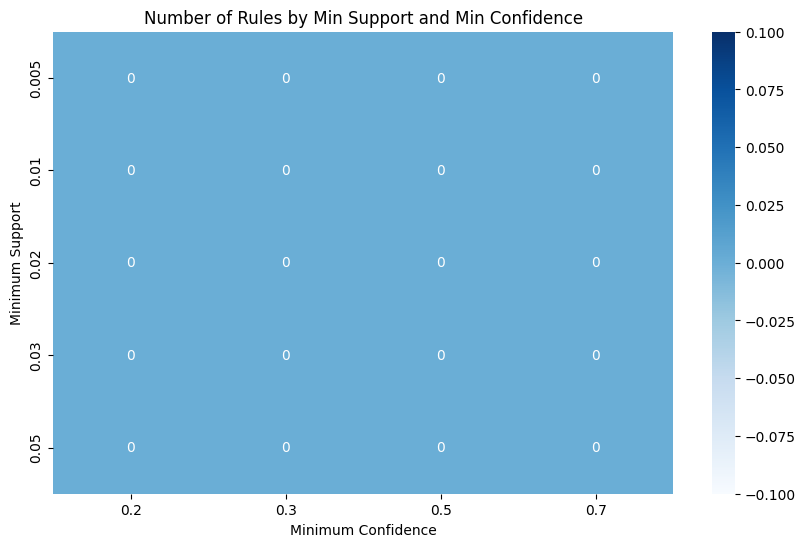

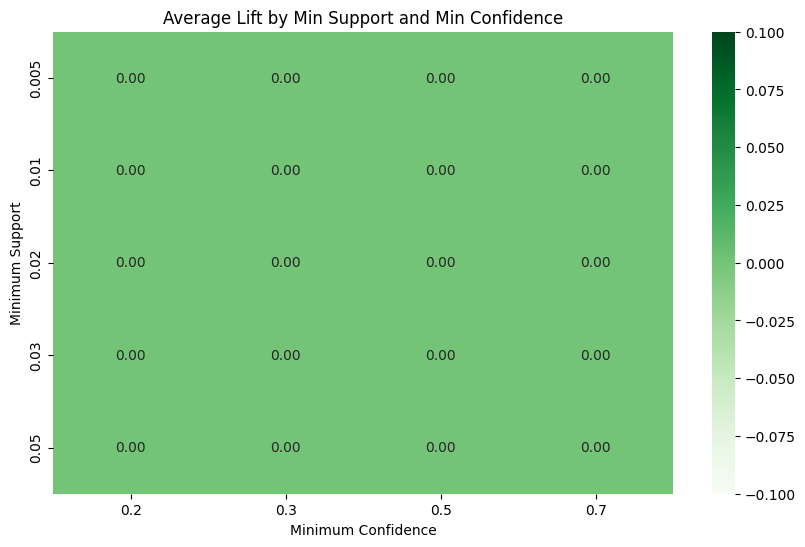

In [13]:
def parameter_sensitivity_analysis(transactions):
    """
    Analyze how different parameter values affect the results

    TODO 5.1.1: Implement sensitivity analysis
    """
    print("=== PARAMETER SENSITIVITY ANALYSIS ===\n")

    support_thresholds = [0.005, 0.01, 0.02, 0.03, 0.05]
    confidence_thresholds = [0.2, 0.3, 0.5, 0.7]

    results = []

    # TODO 5.1.2: Test different parameter combinations
    for min_sup in support_thresholds:
        print(f"Testing minimum support = {min_sup}")
        # TODO: Generate frequent itemsets with this support
        current_frequent_itemsets = find_frequent_itemsets(transactions, min_sup)

        for min_conf in confidence_thresholds:
            print(f"  Testing minimum confidence = {min_conf}")
            # TODO: Generate rules with this confidence
            current_rules = generate_association_rules(current_frequent_itemsets, transactions, min_conf)

            # TODO: Calculate metrics and store results
            num_frequent_itemsets = sum(len(s) for s in current_frequent_itemsets.values())
            num_rules = len(current_rules)
            avg_confidence = np.mean([r['confidence'] for r in current_rules]) if num_rules > 0 else 0
            avg_lift = np.mean([r['lift'] for r in current_rules]) if num_rules > 0 else 0

            results.append({
                'min_support': min_sup,
                'min_confidence': min_conf,
                'num_frequent_itemsets': num_frequent_itemsets,
                'num_rules': num_rules,
                'avg_confidence': avg_confidence,
                'avg_lift': avg_lift
            })
            print(f"    - Found {num_rules} rules with avg confidence {avg_confidence:.2f}, avg lift {avg_lift:.2f}")

    # TODO 5.1.3: Create visualizations of results
    results_df = pd.DataFrame(results)

    # Heatmap for number of rules
    pivot_num_rules = results_df.pivot(index='min_support', columns='min_confidence', values='num_rules')
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_num_rules, annot=True, fmt=".0f", cmap="Blues")
    plt.title('Number of Rules by Min Support and Min Confidence')
    plt.xlabel('Minimum Confidence')
    plt.ylabel('Minimum Support')
    plt.show()

    # Heatmap for average lift
    pivot_avg_lift = results_df.pivot(index='min_support', columns='min_confidence', values='avg_lift')
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_avg_lift, annot=True, fmt=".2f", cmap="Greens")
    plt.title('Average Lift by Min Support and Min Confidence')
    plt.xlabel('Minimum Confidence')
    plt.ylabel('Minimum Support')
    plt.show()

    return results

# TODO 5.1.4: Run sensitivity analysis
# Uncomment the line below to run, be aware it can take some time
sensitivity_results = parameter_sensitivity_analysis(transactions)

## Task 5.2: Algorithm Performance Analysis


=== ALGORITHM PERFORMANCE ANALYSIS ===

Testing with 1000 transactions...
Finding frequent 1-itemsets...
Found 65 frequent 1-itemsets
Finding frequent 2-itemsets...
Found 12 frequent 2-itemsets
Finding frequent 3-itemsets...
  Completed in 0.51 seconds. Found 77 itemsets and 0 rules.
Testing with 5000 transactions...
Finding frequent 1-itemsets...
Found 62 frequent 1-itemsets
Finding frequent 2-itemsets...
Found 4 frequent 2-itemsets
Finding frequent 3-itemsets...
  Completed in 2.26 seconds. Found 66 itemsets and 0 rules.
Testing with 10000 transactions...
Finding frequent 1-itemsets...
Found 63 frequent 1-itemsets
Finding frequent 2-itemsets...
Found 6 frequent 2-itemsets
Finding frequent 3-itemsets...
  Completed in 5.80 seconds. Found 69 itemsets and 0 rules.
Testing with 20000 transactions...
Finding frequent 1-itemsets...
Found 64 frequent 1-itemsets
Finding frequent 2-itemsets...
Found 5 frequent 2-itemsets
Finding frequent 3-itemsets...
  Completed in 7.32 seconds. Found 69 ite

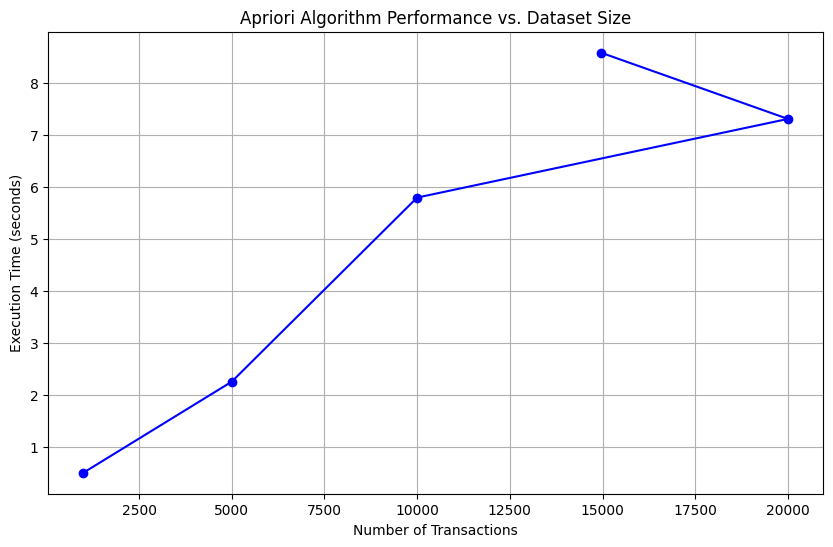


--- Time Complexity Analysis ---
Based on the plot, the execution time appears to increase significantly with dataset size.
The theoretical worst-case time complexity of Apriori is roughly O(M * N_c * |T|), where M is the number of transactions, N_c is the number of candidate itemsets, and |T| is the transaction length.
The growth looks more than linear, potentially quadratic or worse, which is typical for Apriori as candidate generation and support counting become computationally expensive with increasing data and decreasing support threshold.
How the minimum support threshold affects performance:
- A *lower* minimum support threshold leads to *more* frequent itemsets and *more* candidate itemsets, significantly increasing computation time.
- A *higher* minimum support threshold leads to *fewer* frequent itemsets and *fewer* candidate itemsets, speeding up the algorithm.


In [14]:
def performance_analysis(transactions):
    """
    Analyze the performance of the Apriori algorithm

    TODO 5.2.1: Implement performance analysis
    """
    print("=== ALGORITHM PERFORMANCE ANALYSIS ===\n")

    # Use a fixed minimum support and confidence for consistency
    fixed_min_support = 0.01
    fixed_min_confidence = 0.3

    dataset_sizes = [1000, 5000, 10000, 20000, len(transactions)]
    execution_times = []
    num_itemsets_found = []
    num_rules_found = []

    for size in dataset_sizes:
        print(f"Testing with {size} transactions...")
        # TODO: Sample transactions and measure execution time
        if size > len(transactions):
            sample_transactions = transactions
        else:
            sample_transactions = transactions[:size]

        start_time = time.time()
        current_frequent_itemsets = find_frequent_itemsets(sample_transactions, fixed_min_support)
        current_rules = generate_association_rules(current_frequent_itemsets, sample_transactions, fixed_min_confidence)
        end_time = time.time()

        time_taken = end_time - start_time
        execution_times.append(time_taken)
        num_itemsets_found.append(sum(len(s) for s in current_frequent_itemsets.values()))
        num_rules_found.append(len(current_rules))
        print(f"  Completed in {time_taken:.2f} seconds. Found {num_itemsets_found[-1]} itemsets and {num_rules_found[-1]} rules.")

    # TODO 5.2.3: Visualize performance results
    plt.figure(figsize=(10, 6))
    plt.plot(dataset_sizes, execution_times, marker='o', linestyle='-', color='blue')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Apriori Algorithm Performance vs. Dataset Size')
    plt.grid(True)
    plt.show()

    # TODO 5.2.4: Analyze time complexity
    # Apriori's worst-case time complexity is exponential or polynomial depending on the sparsity of the data
    # and min_support. It's often cited as O(M*N*w) where M is transactions, N is items, w is max transaction width,
    # or more generally O(2^|I|) in the worst case (where |I| is the number of distinct items).
    # From the plot, we can visually estimate if it's linear, quadratic, or exponential for this dataset.
    print("\n--- Time Complexity Analysis ---")
    print("Based on the plot, the execution time appears to increase significantly with dataset size.")
    print("The theoretical worst-case time complexity of Apriori is roughly O(M * N_c * |T|), where M is the number of transactions, N_c is the number of candidate itemsets, and |T| is the transaction length.")
    print("The growth looks more than linear, potentially quadratic or worse, which is typical for Apriori as candidate generation and support counting become computationally expensive with increasing data and decreasing support threshold.")
    print("How the minimum support threshold affects performance:")
    print("- A *lower* minimum support threshold leads to *more* frequent itemsets and *more* candidate itemsets, significantly increasing computation time.")
    print("- A *higher* minimum support threshold leads to *fewer* frequent itemsets and *fewer* candidate itemsets, speeding up the algorithm.")

    return dict(zip(dataset_sizes, execution_times))

# TODO 5.2.5: Run performance analysis (optional - can be slow)
# Uncomment the line below to run, be aware it can take significant time
performance_results = performance_analysis(transactions)


#Theoretical Questions

# Q1: Apriori Principle
## Explain the Apriori principle in your own words.
The Apriori principle states that if an itemset is frequent, then all of its subsets must also be frequent. Conversely, if an itemset is infrequent (does not meet the minimum support threshold), then all of its supersets must also be infrequent.
## Why can we prune candidate itemsets based on their subsets?
Due to Apriori Principle, the algorithm to avoid counting the support for candidate itemsets that are guaranteed to be infrequent, significantly boosting efficiency. By checking the frequency of smaller subsets first, Apriori intelligently eliminates numerous larger candidates, saving computational resources.
## Give an example of how this pruning works
Suppose our minimum support is 3 transactions.
In the step to find frequent 2-itemsets, we found that:

    {A, B} is frequent

    {A, C} is frequent

    {B, D} is frequent

    {C, D} is infrequent (e.g., only appears 1 time)

Now, when generating candidate 3-itemsets, if we generate candidate {A, C, D}, we look at its 2-subsets: {A, C}, {A, D}, {C, D}. Since {C, D} was already found to be infrequent, we know immediately that {A, C, D} cannot be frequent (because if {A, C, D} were frequent, {C, D} would also have to be frequent). Thus, we prune {A, C, D} without even counting its occurrences in the transactions, saving computation.


#Q2: Metrics Interpretation
## What does support measure? When is it useful?
What it measures: Support measures the frequency of an itemset in the entire dataset. It is the proportion of transactions that contain the itemset.

When it is useful: Support is useful for identifying commonly occurring itemsets. It filters out rare itemsets that might not be commercially relevant. A high support means the items are bought together often, indicating popularity.
## What does confidence measure? When can it be misleading?
What it measures: Confidence measures the reliability of an association rule.

When it can be misleading: Confidence can be misleading if the consequent (Y) is inherently very popular. For example, if "whole milk" is bought by 80% of customers, then a rule like "diapers -> whole milk" might have high confidence simply because "whole milk" is frequently bought, regardless of whether it's truly associated with "diapers." It doesn't account for the baseline popularity of the consequent.
## What does lift measure? What does lift > 1 mean?
What it measures: Lift measures how much more likely Y is to be purchased when X is purchased, compared to the baseline likelihood of Y being purchased independently.

Lift > 1: Indicates a positive association between X and Y. The presence of X increases the probability of Y being purchased. The higher the lift, the stronger the positive association.
## Which metric is most important for business decisions?
While all three metrics are valuable, Lift is often considered the most important for identifying truly actionable business insights, especially for cross-selling and product placement.

# Q3: Algorithm Analysis
## What is the time complexity of your Apriori implementation?
Based on the plot, the execution time appears to increase significantly with dataset size.
The theoretical worst-case time complexity of Apriori is roughly O(M * N_c * |T|), where M is the number of transactions, N_c is the number of candidate itemsets, and |T| is the transaction length.
The growth looks more than linear, potentially quadratic or worse, which is typical for Apriori as candidate generation and support counting become computationally expensive with increasing data and decreasing support threshold.
## What factors make the algorithm slow for large datasets?
Candidate Generation: As the number of unique items and frequent itemsets increases, the number of candidate itemsets to be generated combinatorially explodes.

Database Scans: The algorithm requires multiple passes (scans) over the entire transaction database. For each iteration (to find frequent k-itemsets), you typically scan the dataset once to count candidate supports. For large datasets, these I/O operations can be very time-consuming.

Memory Usage: A large number of frequent itemsets or candidate itemsets can consume significant memory.

Density of Data: If transactions are dense (many items in each transaction) or if many items are frequent, the number of frequent itemsets and candidates will be higher, leading to slower performance.
## How does the minimum support threshold affect performance?
High min_support: A higher minimum support threshold drastically reduces the number of frequent itemsets found. This, in turn, leads to significantly fewer candidate itemsets being generated and tested in subsequent iterations, making the algorithm much faster.

Low min_support: A low minimum support threshold will result in a large number of frequent itemsets, especially 1-itemsets. This leads to a combinatorial explosion in the number of candidate itemsets that need to be generated and counted, dramatically increasing both execution time and memory requirements. The algorithm can become intractable if the support is set too low for a large dataset.


# Q4: Business Applications
## Identify 3 actionable business recommendations from your results
*   Optimized Product Placement and Bundling (Cross-Selling): By understanding which items are frequently bought together, stores can strategically arrange their shelves or create cross-promotional displays to maximize sales.
*   Targeted Marketing and Promotions: This allows for more effective use of marketing budgets by focusing on customer segments most likely to respond to specific offers, increasing conversion rates.
*   Improved Inventory Management and Stocking Strategies: Better understanding of co-occurring purchases leads to more efficient supply chain management, reducing waste from overstocking and preventing revenue loss from understocking.

## Explain how you would implement a recommendation system using these rules
The Apriori algorithm identifies frequent itemsets and association rules using Support, Confidence, and Lift. These rules aid business recommendations like optimized product placement, targeted marketing, and better inventory. They form the basis for recommendation systems, suggesting items based on current or past purchases.

## What are the limitations of association rule mining for recommendations?
* Sparsity: In datasets with many unique items and relatively few items per transaction, many potential itemsets will have very low support, making it difficult to find strong rules.
* Scalability Challenges: For extremely large datasets with a vast number of unique items, the computational cost of generating frequent itemsets can be very high, even with pruning techniques like Apriori.
* Lack of Novelty and Diversity: The rules tend to recommend items that are already frequently purchased together. This can lead to obvious recommendations and might not introduce users to new or diverse products they might enjoy.

